## Imports

In [12]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef, precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import random
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

### Loading Word2Vec Feature Matrix


In [6]:
df = pd.read_csv('Data/Word2Vec_feature_data.csv')
df

,author_ID,average_word_length,avg_sentence_length,ttr,nr_unique_words,nr_chars,nr_contradictions,subjectivity,nr_period,nr_comma,...,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,Poles
0,t2_ffcfiueh,5.481442,66.164835,0.707317,667,6111,6,0.485495,0.091198,0.047720,...,0.030382,-0.038984,0.082427,0.027456,-0.110414,-0.035993,-0.043381,0.027923,-0.085713,Western
1,t2_lfs48,6.285714,85.014925,0.718078,568,5762,17,0.487030,0.113780,0.078382,...,-0.002733,-0.035620,0.086639,0.089150,-0.005477,-0.005393,-0.010546,0.005088,-0.034315,Western
2,t2_zcj4y,5.580460,34.134969,0.747126,650,5724,18,0.551005,0.174713,0.065517,...,0.041019,-0.025408,0.076059,0.078353,-0.077311,-0.021945,-0.051248,-0.023123,-0.007378,Western
3,t2_2xpu7n1c,5.481297,75.441176,0.640898,514,5197,0,0.514366,0.073566,0.112219,...,0.059938,-0.004517,0.064531,0.129023,-0.062811,0.001734,-0.053279,-0.044899,0.018924,Western
4,t2_3edl7,5.916865,60.968085,0.719715,606,5823,11,0.401854,0.122328,0.085511,...,-0.016096,-0.002657,0.096512,0.061793,-0.128142,0.001301,-0.059142,0.026707,-0.030807,Western
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30934,t2_8hacr7if,5.697468,49.875000,0.683544,540,5290,13,0.437244,0.111392,0.037975,...,-0.054445,-0.005667,0.073418,0.111456,-0.142758,-0.026188,-0.088024,0.020324,-0.023312,Eastern
30935,t2_8hacr7if,5.790725,50.450450,0.744352,626,5710,9,0.436489,0.109394,0.048751,...,-0.053965,0.010229,0.090820,0.098168,-0.123997,0.001711,-0.086069,0.063151,-0.029690,Eastern
30936,t2_8hacr7if,5.671835,47.716981,0.700258,542,5163,9,0.466545,0.131783,0.047804,...,0.012857,-0.056423,0.078301,0.113703,-0.119587,-0.012560,-0.153321,0.051385,-0.040174,Eastern
30937,t2_8hacr7if,5.748459,47.866071,0.704069,571,5472,7,0.428413,0.114673,0.053021,...,0.011493,-0.041948,0.091651,0.121716,-0.118058,-0.020970,-0.146114,0.043594,-0.022459,Eastern


In [8]:
# y data
y = df['Poles']

# Creating X dataframe with document embeddings
X = df.drop(['author_ID', 'Poles', ], axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## NN Evaluation Metrics

Note: The optimal hyperparameter value for the Neural Network were obtained through hyper-tuning and plotting the loss graphs for testing and training. The last section can be run to see all the testing and training loss graphs for each combination of hyper-parameter.

In [10]:
# Set a seed for reproducibility
seed_value = 21
np.random.seed(seed_value)
random.seed(seed_value)

# Standardize features for neural networks
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize neural network model
clf = MLPClassifier(hidden_layer_sizes=(5,), max_iter=1, warm_start=True, alpha=0.01, learning_rate_init=0.0001)

# Number of training iterations (epochs)
n_epochs = 250

# Variables for early stopping
best_test_mcc = float('-inf')
patience = 15  # Number of epochs with no improvement after which training will be stopped
no_improvement_count = 0

# Train the model in multiple epochs
for epoch in range(n_epochs):
    # Train the model with a small batch of data
    clf.partial_fit(X_train_scaled, y_train, classes=np.unique(y_train))

    # Calculate MCC on the test set
    y_pred_test = clf.predict(X_test_scaled)
    mcc_test = matthews_corrcoef(y_test, y_pred_test)

    # Early stopping
    if mcc_test > best_test_mcc:
        best_test_mcc = mcc_test
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        if no_improvement_count == patience:
            print(f'Early stopping at epoch {epoch + 1} as test MCC did not improve.')
            break

# Calculate precision, recall, F1 score, and accuracy for each class on the test set
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_test, average=None)

# Print precision, recall, F1 score for each class
for i in range(len(precision)):
    print(f'Class {i + 1}:')
    print(f'  Precision: {precision[i]}')
    print(f'  Recall: {recall[i]}')
    print(f'  F1 Score: {fscore[i]}')

# Print accuracy
accuracy = accuracy_score(y_test, y_pred_test)
print(f'Accuracy: {accuracy}')

# Print the final MCC value on the test set
print(f'Final MCC on the test set: {best_test_mcc}')

Early stopping at epoch 147 as test MCC did not improve.
Class 1:
  Precision: 0.8617449664429531
  Recall: 0.8397645519947678
  F1 Score: 0.850612785690626
Class 2:
  Precision: 0.8472568578553616
  Recall: 0.868370607028754
  F1 Score: 0.857683811928053
Accuracy: 0.8542340012928248
Final MCC on the test set: 0.7101903404172512


## Testing and Training loss graph

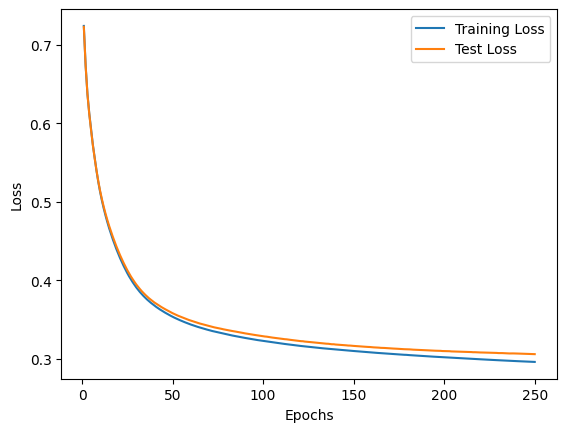

In [14]:
# Standardize features for neural networks
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize neural network model
clf = MLPClassifier(hidden_layer_sizes=(5,), max_iter=1, warm_start=True, alpha=0.01, learning_rate_init=0.0001)

# Lists to store training and test losses
train_losses = []
test_losses = []

# Number of training iterations (epochs)
n_epochs = 250

# Variables for early stopping
best_test_loss = float('inf')
patience = 15  # Number of epochs with no improvement after which training will be stopped
no_improvement_count = 0

# Train the model in multiple epochs
for epoch in range(n_epochs):
    # Train the model with a small batch of data
    clf.partial_fit(X_train_scaled, y_train, classes=np.unique(y_train))

    # Compute the loss on the training set
    train_predictions_proba = clf.predict_proba(X_train_scaled)
    train_loss = log_loss(y_train, train_predictions_proba)
    train_losses.append(train_loss)

    # Compute the loss on the test set
    test_predictions_proba = clf.predict_proba(X_test_scaled)
    test_loss = log_loss(y_test, test_predictions_proba)
    test_losses.append(test_loss)

    # Early stopping
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        if no_improvement_count == patience:
            print(f'Early stopping at epoch {epoch+1} as test loss did not improve.')
            break

# Plot training and test losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Hyper-parameter tuning

Note: This cell takes a long time to run as it produces 27 graphs

Early stopping at epoch 48 for Hidden Layers: (2,), LR: 0.001, Alpha: 0.001


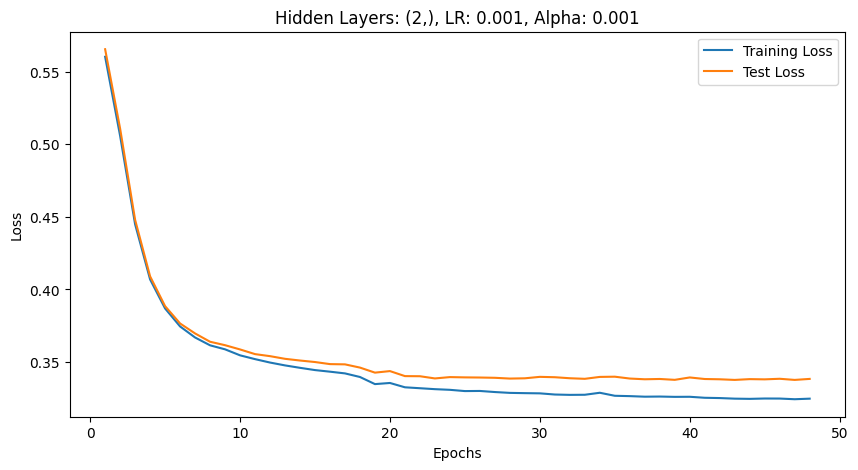

Early stopping at epoch 26 for Hidden Layers: (2,), LR: 0.001, Alpha: 0.01


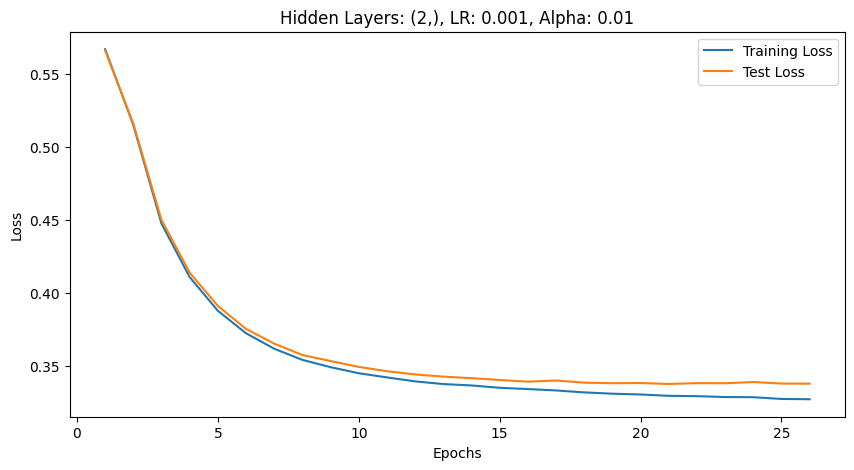

Early stopping at epoch 74 for Hidden Layers: (2,), LR: 0.001, Alpha: 0.1


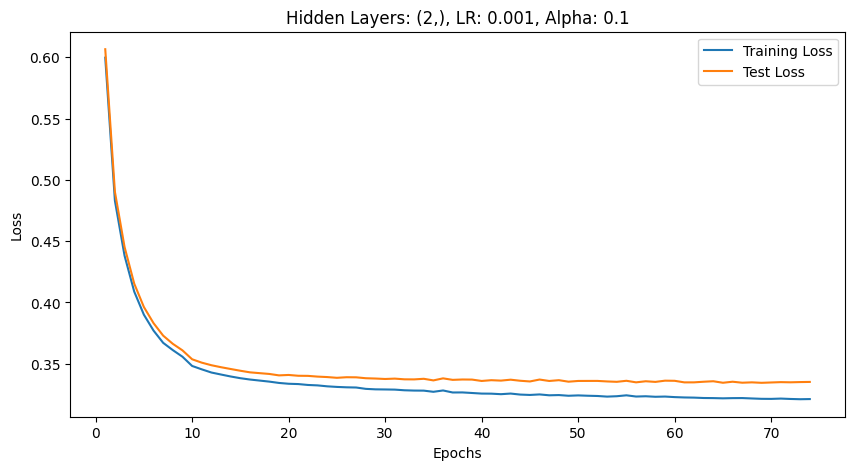

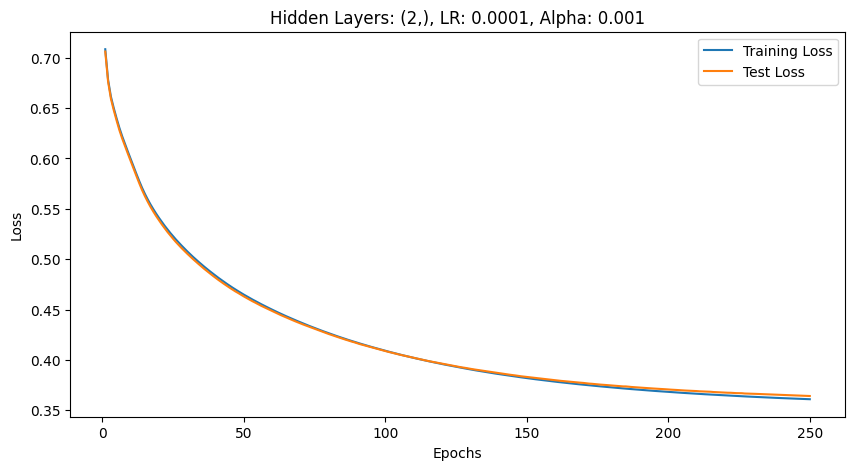

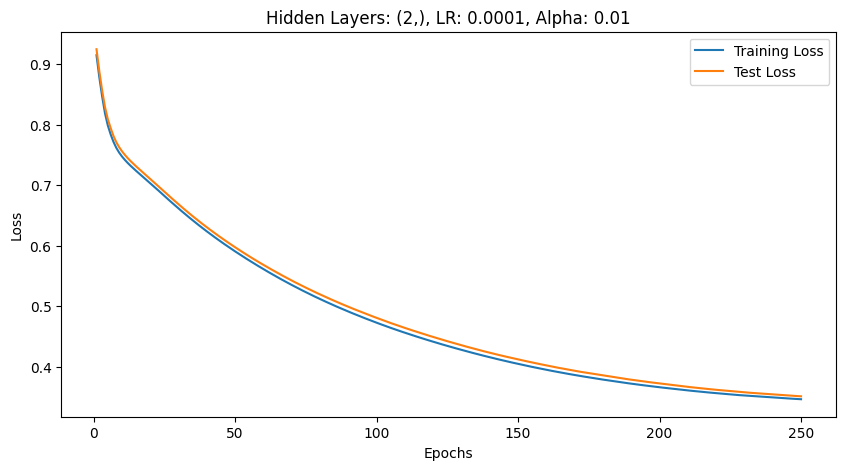

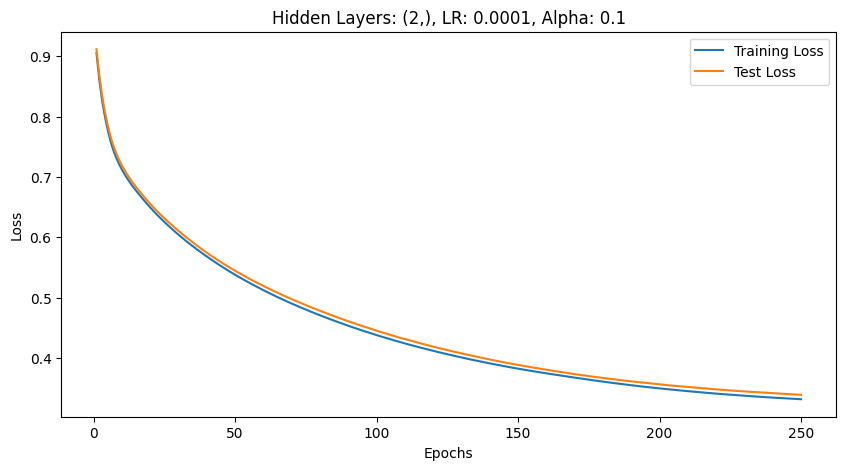

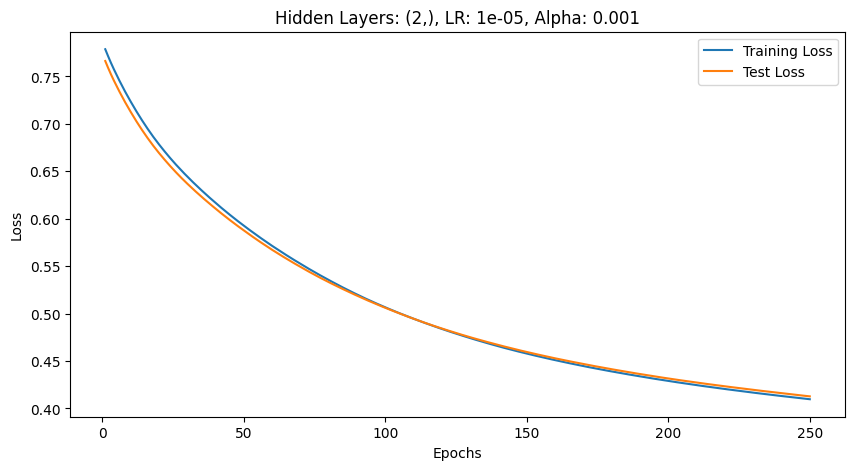

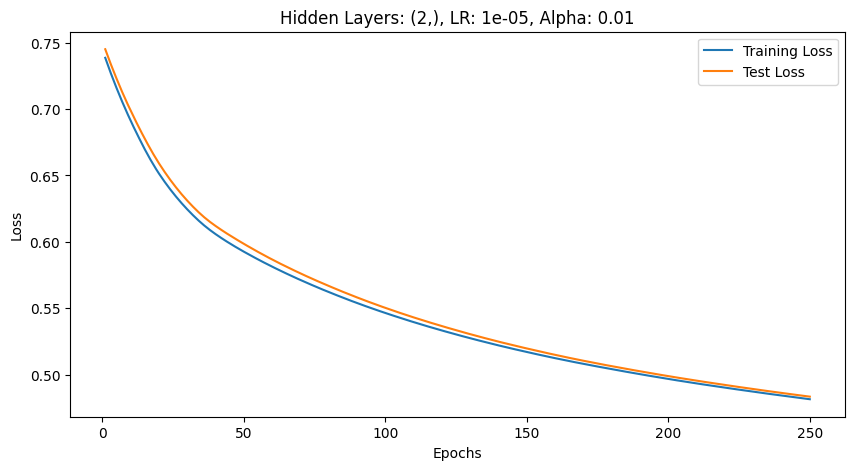

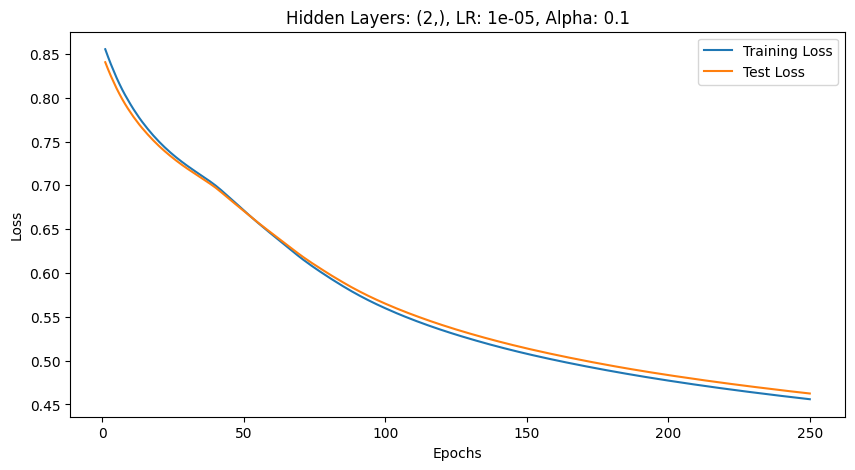

Early stopping at epoch 56 for Hidden Layers: (5,), LR: 0.001, Alpha: 0.001


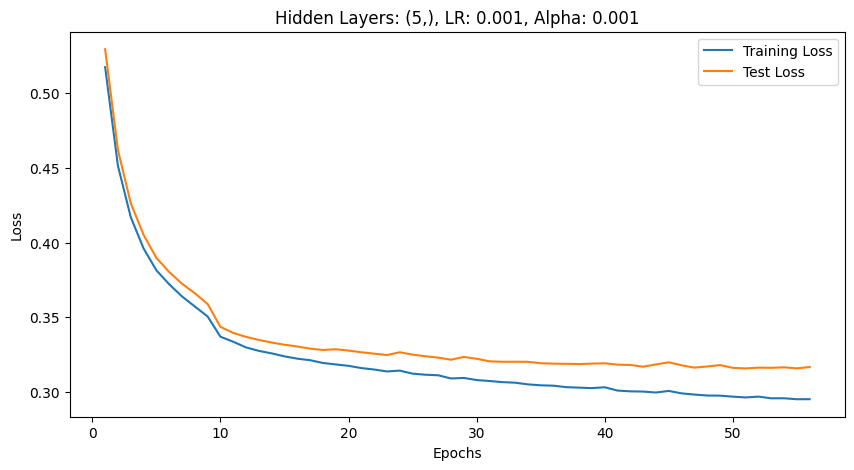

Early stopping at epoch 71 for Hidden Layers: (5,), LR: 0.001, Alpha: 0.01


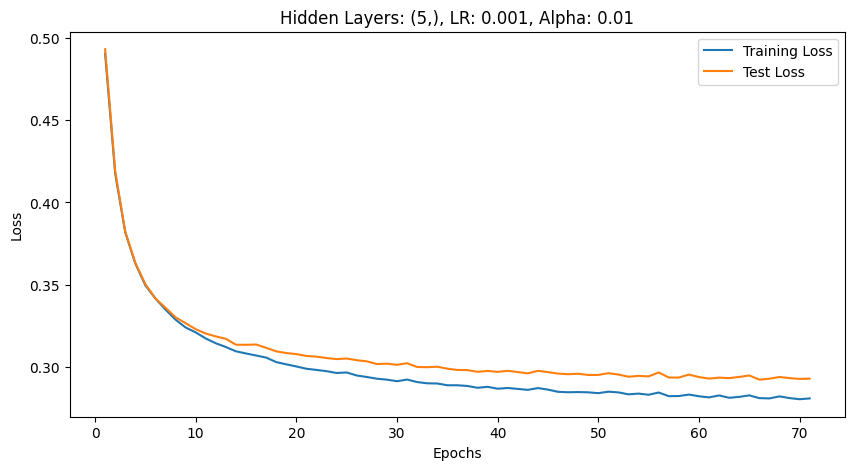

Early stopping at epoch 51 for Hidden Layers: (5,), LR: 0.001, Alpha: 0.1


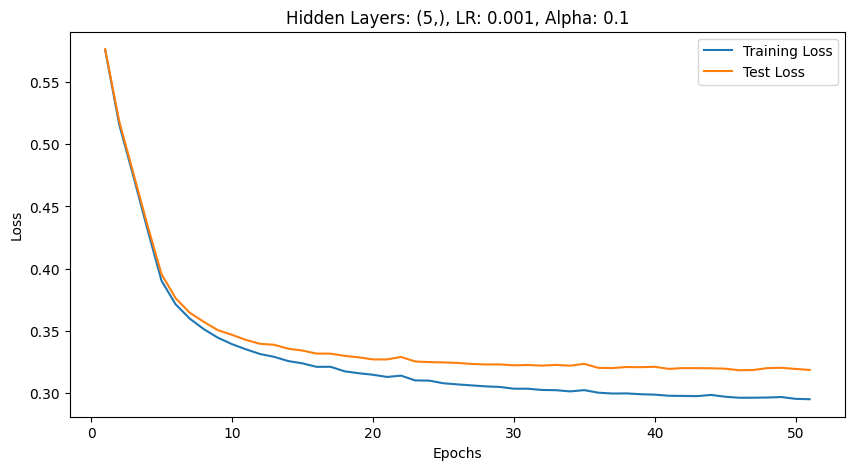

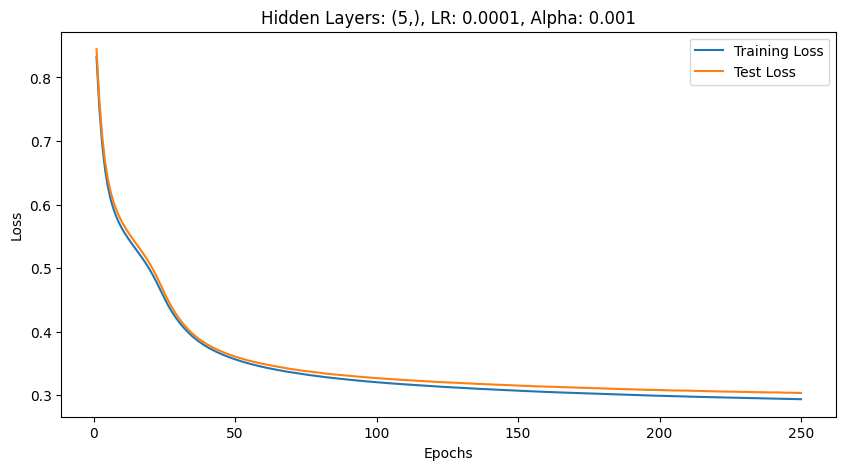

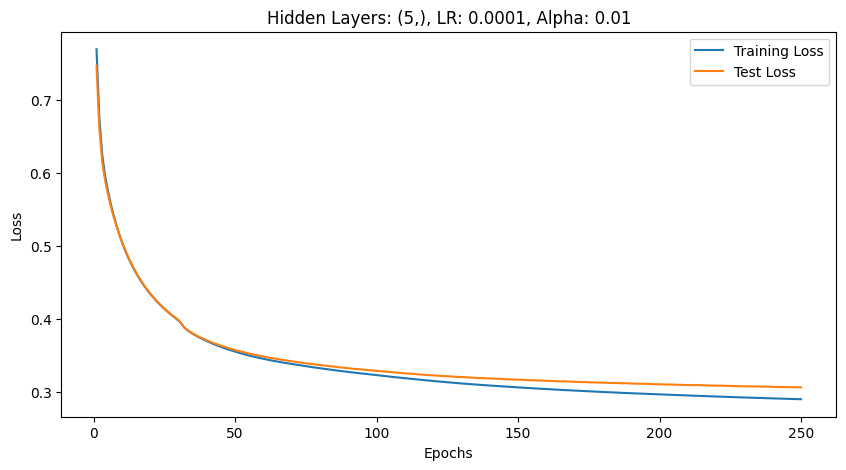

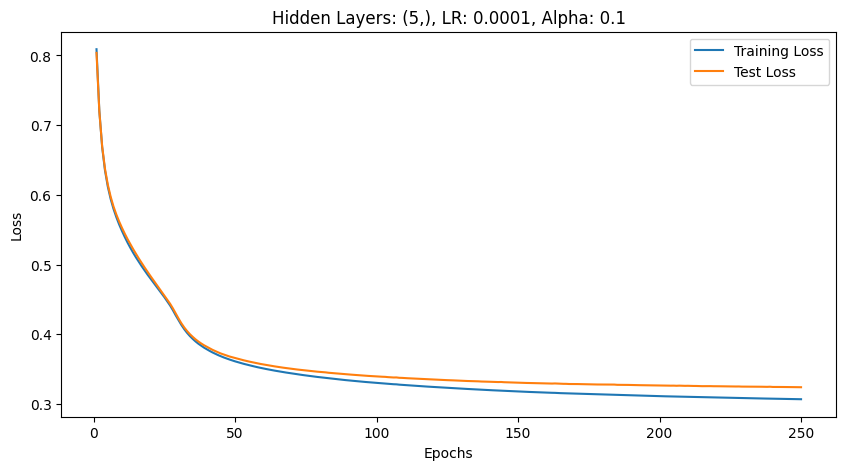

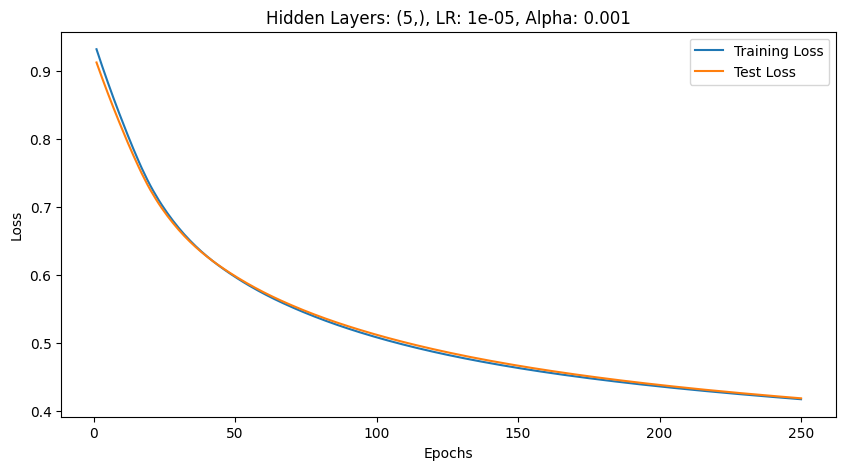

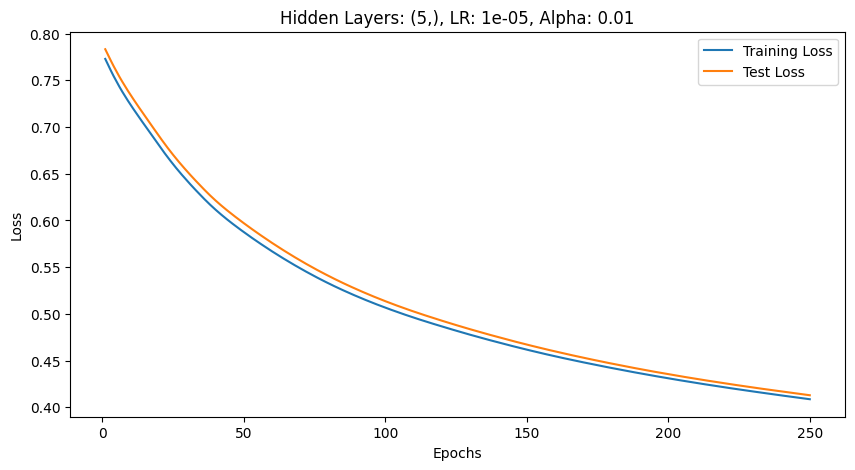

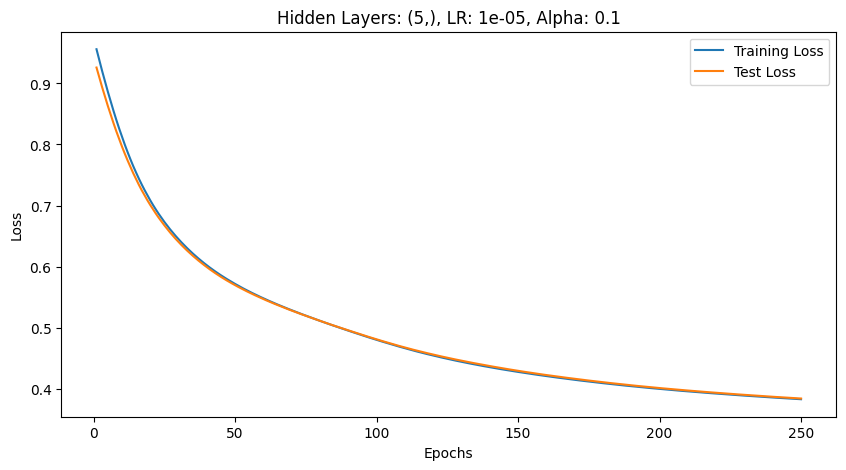

Early stopping at epoch 54 for Hidden Layers: (10,), LR: 0.001, Alpha: 0.001


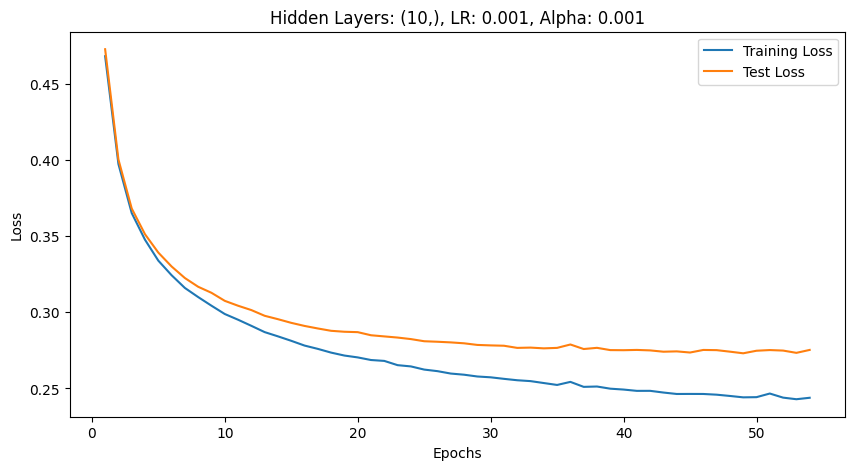

Early stopping at epoch 46 for Hidden Layers: (10,), LR: 0.001, Alpha: 0.01


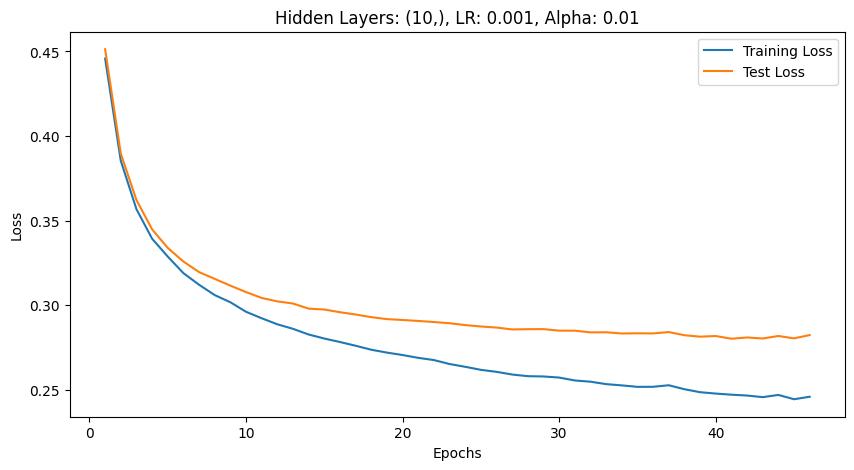

Early stopping at epoch 81 for Hidden Layers: (10,), LR: 0.001, Alpha: 0.1


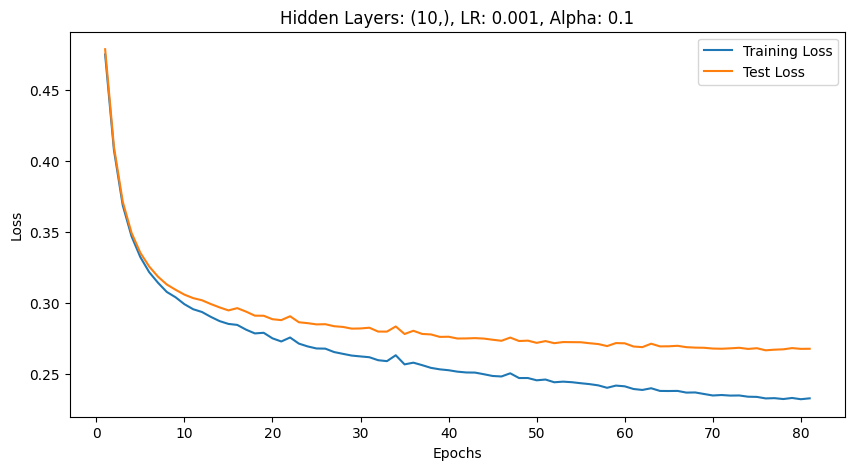

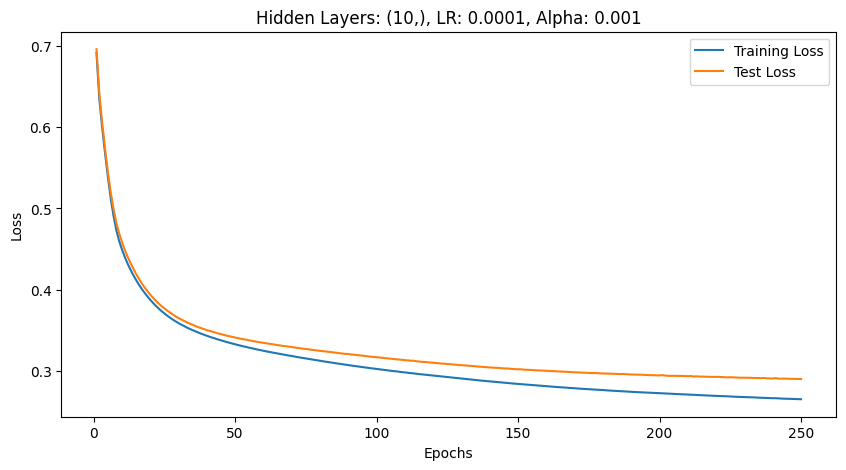

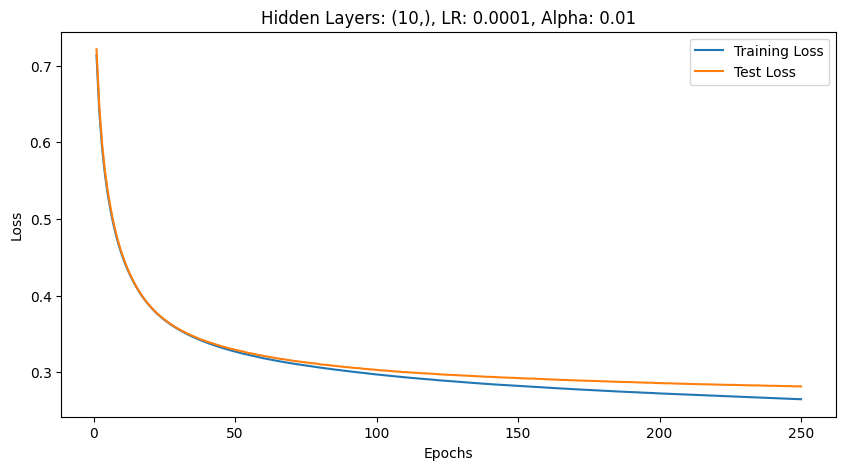

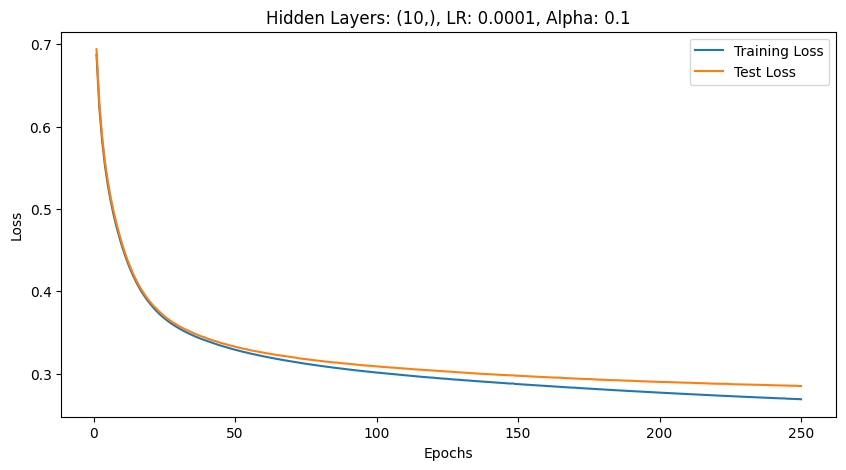

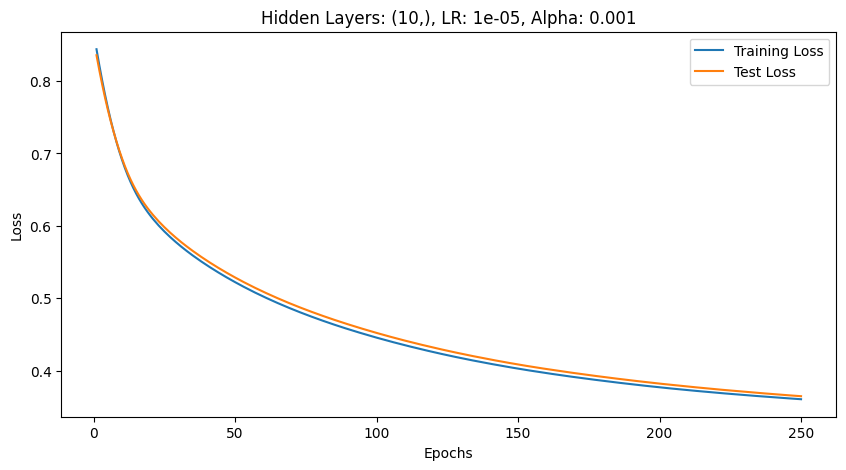

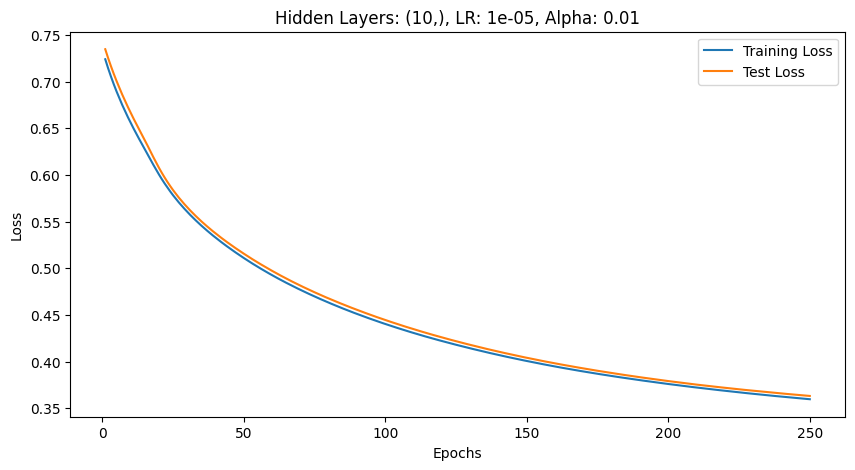

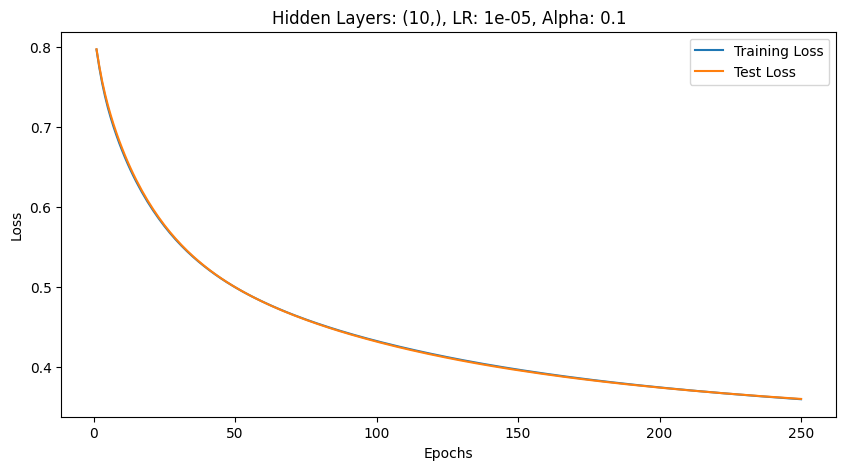

In [15]:
# Standardize features for neural networks
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter values to test
hidden_layer_sizes_values = [(2,), (5,), (10,)]
learning_rate_init_values = [0.001, 0.0001, 0.00001]
alpha_values = [0.001, 0.01, 0.1]

# Number of training iterations (epochs)
n_epochs = 250

# Variables for early stopping
best_test_loss = float('inf')
patience = 5 # Number of epochs with no improvement after which training will be stopped

# Iterate over hyperparameter combinations
for i, hidden_layer_sizes in enumerate(hidden_layer_sizes_values):
    for j, learning_rate_init in enumerate(learning_rate_init_values):
        for k, alpha_value in enumerate(alpha_values):
            # Initialize neural network model
            clf = MLPClassifier(
                hidden_layer_sizes=hidden_layer_sizes,
                max_iter=1,
                warm_start=True,
                alpha=alpha_value,
                learning_rate_init=learning_rate_init
            )

            # Lists to store training and test losses
            train_losses = []
            test_losses = []

            # Variables for early stopping
            best_test_loss = float('inf')
            no_improvement_count = 0

            # Train the model in multiple epochs
            for epoch in range(n_epochs):
                # Train the model with a small batch of data
                clf.partial_fit(X_train_scaled, y_train, classes=np.unique(y_train))

                # Compute the loss on the training set
                train_predictions_proba = clf.predict_proba(X_train_scaled)
                train_loss = log_loss(y_train, train_predictions_proba)
                train_losses.append(train_loss)

                # Compute the loss on the test set
                test_predictions_proba = clf.predict_proba(X_test_scaled)
                test_loss = log_loss(y_test, test_predictions_proba)
                test_losses.append(test_loss)

                # Early stopping
                if test_loss < best_test_loss:
                    best_test_loss = test_loss
                    no_improvement_count = 0
                else:
                    no_improvement_count += 1
                    if no_improvement_count == patience:
                        print(f'Early stopping at epoch {epoch + 1} '
                              f'for Hidden Layers: {hidden_layer_sizes}, LR: {learning_rate_init}, Alpha: {alpha_value}')
                        break

            # Plot the results
            plt.figure(figsize=(10, 5))
            plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
            plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title(f'Hidden Layers: {hidden_layer_sizes}, LR: {learning_rate_init}, Alpha: {alpha_value}')
            plt.legend()
            plt.show()